# TP2: Compensation de Mouvement

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tqdm
import itertools

Comme au tp1, on ouvre les images et on les convertit en arrays numpy:

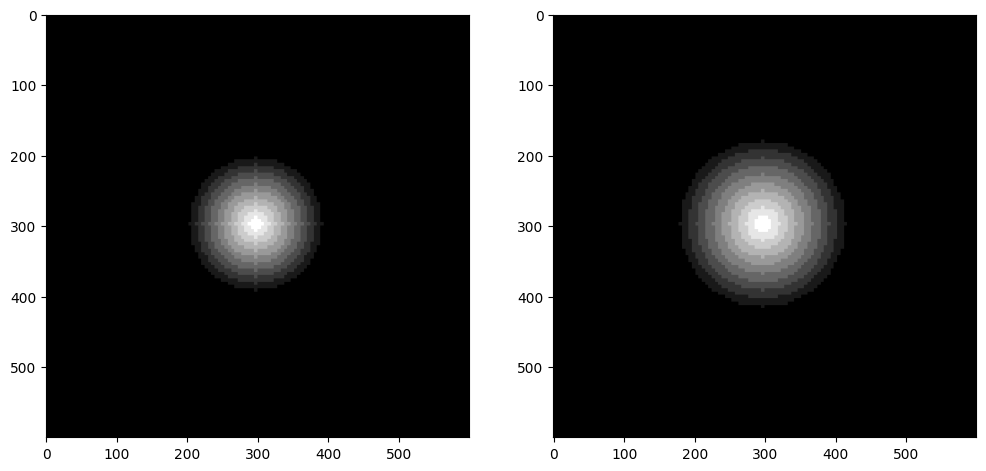

In [2]:
F1 = Image.open("../images_synthetiques/1.png").convert("L")
F2 = Image.open("../images_synthetiques/2.png").convert("L")

_, ax = plt.subplots(1,2, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
plt.show()

F1 = np.asarray(F1)
F2 = np.asarray(F2)

### Question A:

On défini encore une fois nos fonctions, cette fois ci en backwards plutot que forward.

In [3]:
def reconstruct_block(image, displacementX, displacementY, block_size):
    x,y = np.meshgrid(np.arange(600), np.arange(600))
    full_Dx = displacementX.repeat(block_size, axis=0).repeat(block_size, axis=1)
    full_Dy = displacementY.repeat(block_size, axis=0).repeat(block_size, axis=1)
    res = image[np.clip(x + full_Dx, 0, 599), np.clip(y + full_Dy, 0, 599)]
    return res

In [4]:
def intensity_B_diff(first, second, x, y, block_size, offsetx=0, offsety=0):
    startx1 = x * block_size + offsetx
    starty1 = y * block_size + offsety
    endx1 = x * (block_size + 1) + offsetx
    endy1 = y * (block_size + 1) + offsety
    startx2 = x * block_size
    starty2 = y * block_size
    endx2 = x * (block_size + 1)
    endy2 = y * (block_size + 1)
    return abs(second[startx2: endx2, starty2: endy2] - first[startx1: endx1, starty1:endy1]).astype(int).sum()

def find_new_block(by, bx, r, block_size):
    I = intensity_B_diff(F1, F2, bx, by, block_size)
    if I == 0:
        return (0,0)
    point = None
    lowest = None
    d = None
    for offx in range(-r + 1, r):
        if bx * block_size - offx < 0 or bx * block_size + offx > 600:
            continue
        for offy in range(-r + 1, r):
            if by * block_size - offy < 0 or by * block_size + offy > 600:
                continue
            diff = intensity_B_diff(F1, F2, bx ,by, block_size, offx, offy)
            if not point or diff < lowest:
                lowest = diff
                point = (bx * block_size + offx, by * block_size + offy)
                d = offx ** 2 + offy ** 2
            elif diff == lowest:
                d2 = offx ** 2 + offy ** 2
                if d > d2:
                    d = d2
                    point = (bx * block_size + offx, by * block_size + offy)
    return (point[0] - bx * block_size, point[1] - by * block_size)

On éstime ensuite nos mouvements, comme dans le tp1:

In [5]:
#Block based

n_blocks = 30
block_size = 600 // n_blocks

B_Dx = np.array([[0] * n_blocks] * n_blocks)
B_Dy = np.array([[0] * n_blocks] * n_blocks)

for i in range(n_blocks):
    for j in range(n_blocks):
        B_Dx[i,j], B_Dy[i,j] = find_new_block(i, j, 20, block_size)

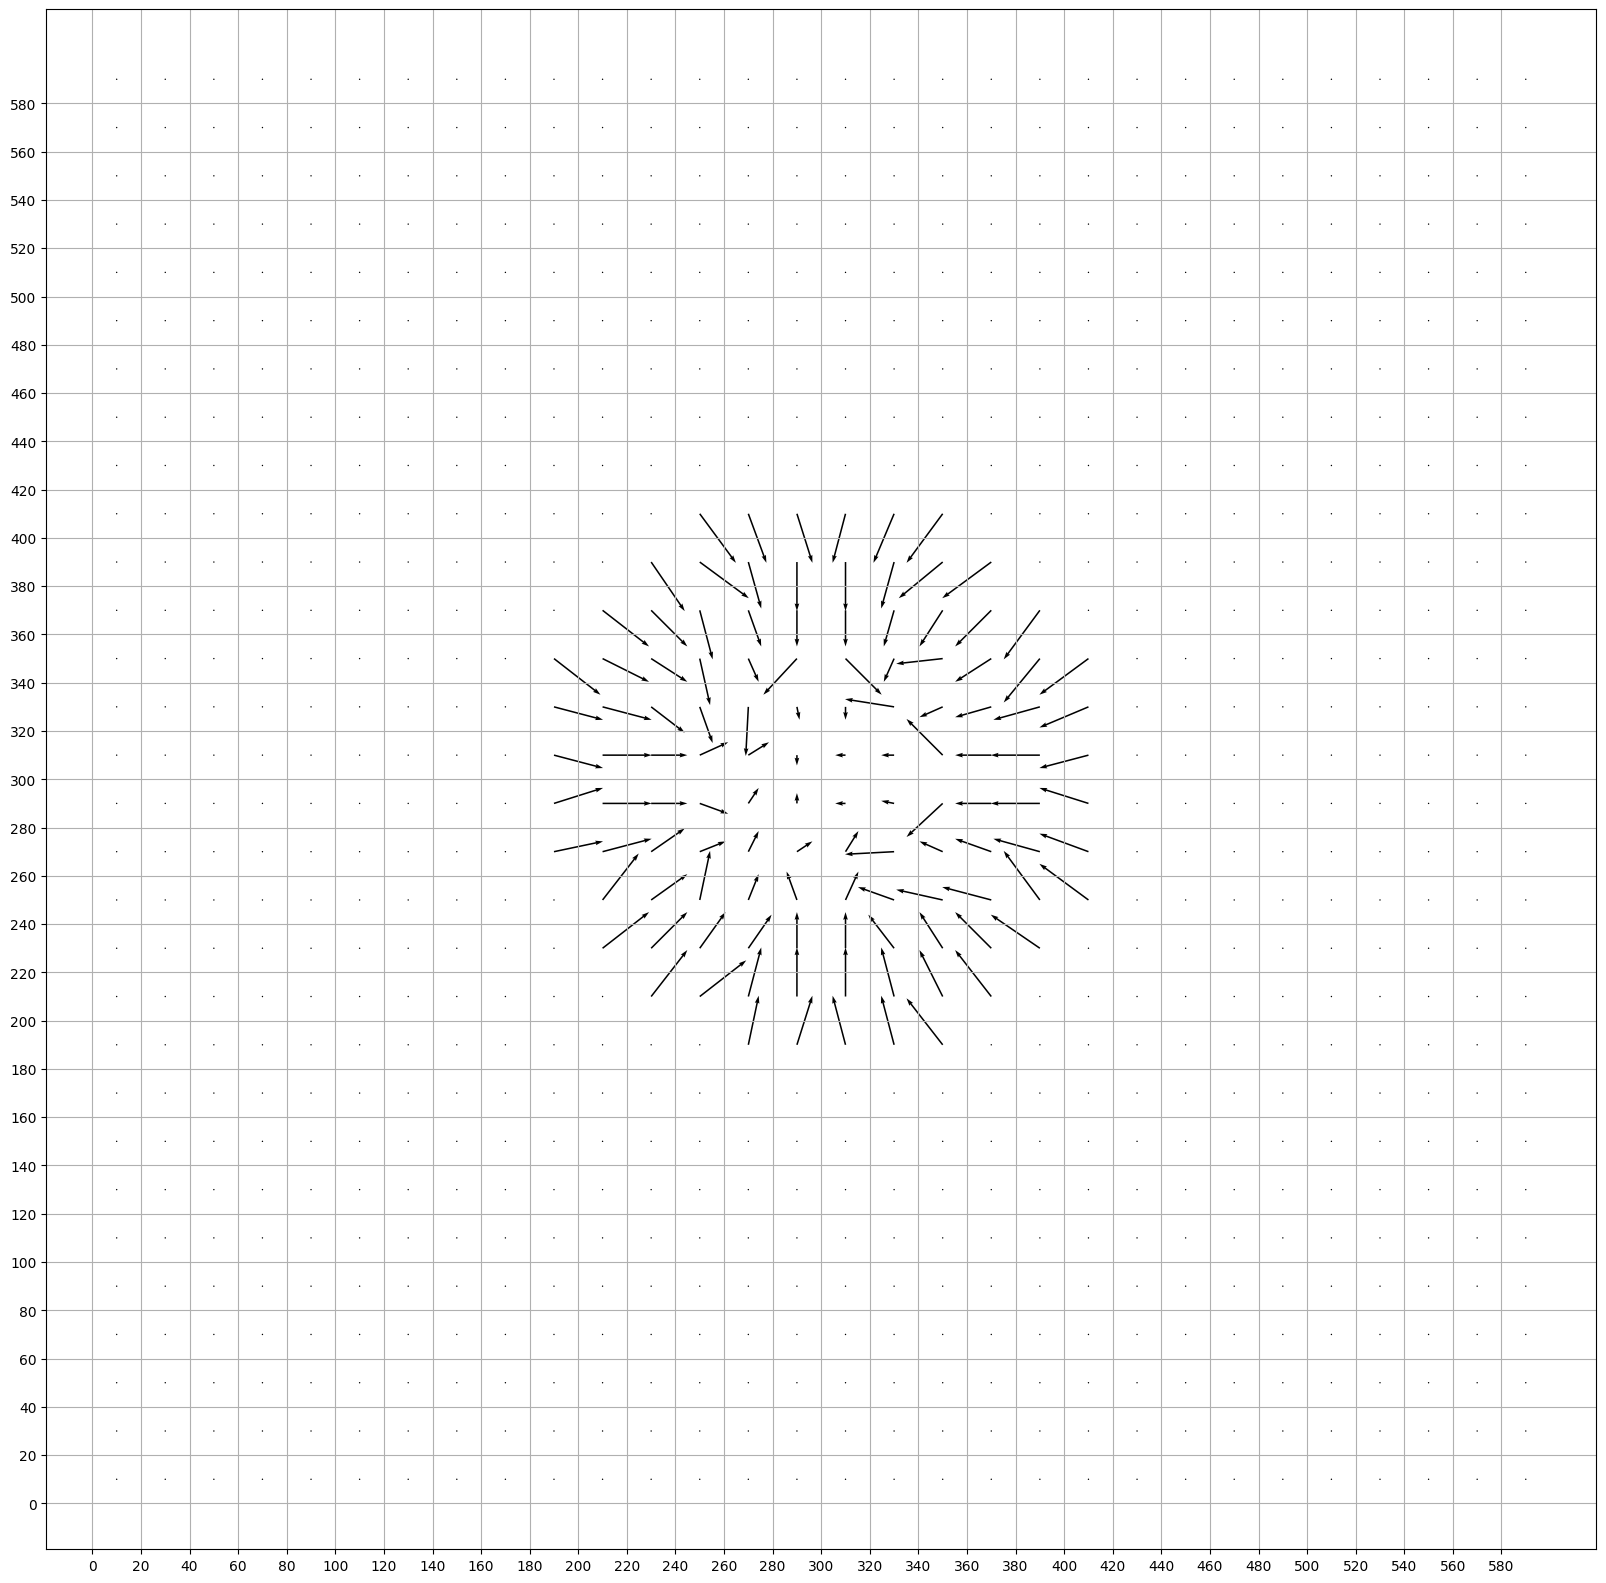

In [6]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(np.arange(n_blocks) * block_size)
ax.set_yticks(np.arange(n_blocks) * block_size)
ax.grid()
O_x = np.tile(np.arange(block_size // 2, block_size * n_blocks, block_size), n_blocks)
O_y = np.arange(block_size // 2, block_size * n_blocks, block_size).repeat(n_blocks)
ax.quiver(O_x.flatten(), O_y.flatten(), B_Dx, B_Dy, scale=600, width=0.001)
plt.show()

A noter: les flèches sont dans le sens contraire par rapport au tp précédent, ce qui est logique puisque on regarde d'ou viennent les pixels dans l'image F2.

### Question B:

Si l'on avait utilisé de la reconstruction forward, alors en déplaçant les blocs de F1, on se retrouverait avec des trous et des superpositions entre les blocs, à part si chaque bloc à un déplacement précis qui reconstruit l'image parfaitement. En utilisant la méthode backwards, on se retrouve sans cela, puisque chaque région de F2 doit forcément venir de quelque part. On a donc pas à se soucier de combler ces trous ou bien de traiter les superpositions. 

### Question C:

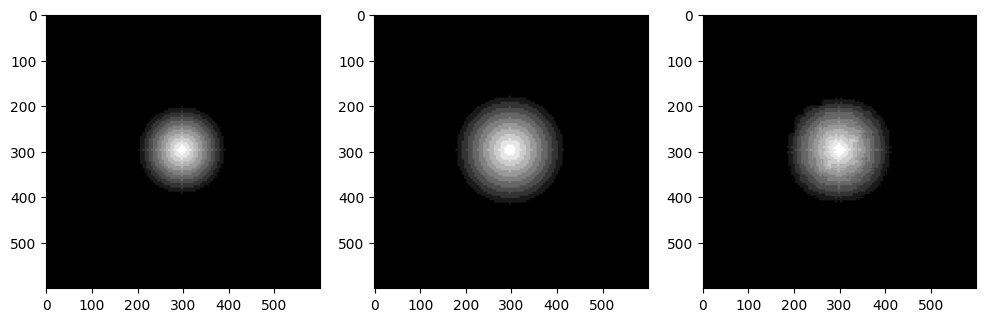

In [7]:
reconstructed = reconstruct_block(F1, B_Dx, B_Dy, block_size)

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed, cmap='gray')
plt.show()

In [8]:
def MSE(first, second):
    return np.square(first - second).sum()

print(f"La MSE de cette méthode est {MSE(F2, reconstructed)}")
print(f"Par comparaison, la MSE entre les deux images de base est {MSE(F1, F2)}")

La MSE de cette méthode est 1166243
Par comparaison, la MSE entre les deux images de base est 3614946


### Question D:

En plus de la taille des blocs, on a besoin de ces différentes valeurs si l'on veut reconstruire l'image parfaitement:

- l'image originale évidemment
- les vecteurs de déplacements que l'on vient de créer
- l'erreur de prédiction, qui donnera les valeurs à rajouter à la prédiction

### Question E

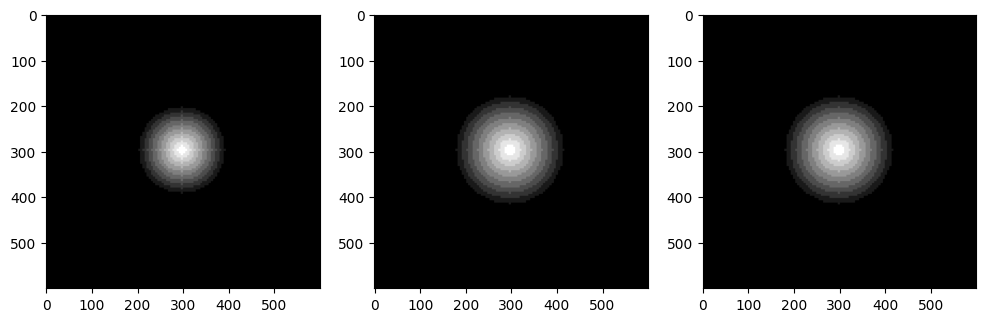

In [9]:
E = F2 - reconstructed

reconstructed_perfect = reconstructed + E

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed_perfect, cmap='gray')
plt.show()

In [10]:
print(f"Comme prévu, la MSE de cette méthode est {MSE(F2, reconstructed_perfect)}")

Comme prévu, la MSE de cette méthode est 0


### Question F

Définissons des fontions qui nous serviront:

In [11]:
# On défini la fonction de RLE pour encoder les infos
def RLE(arr):
    res = []
    zero_count = 0
    flat = arr.flatten()
    for val in flat:
        if val == 0:
            zero_count += 1
        else:
            res.append((zero_count, val))
            zero_count = 0
    res.append((0,0)) # Fin de bloc, reste que des 0
    return np.array(res).astype(np.int8)

def decode_RLE_block(block):
    res = []
    for (n_zero, val) in block:
        if n_zero == 0 and val == 0: # Fin de bloc, reste que des 0
            rest = block_size * block_size - len(res)
            if rest > 0:
                res.extend([0 for i in range(rest)])
            return np.array(res).reshape((block_size, block_size))
        
        if n_zero > 0:
            res.extend([0 for i in range(n_zero)])
        res.append(val)
    return np.array(res).reshape((block_size, block_size))

def decode_RLE(encoded):
    res = np.array([[[0] * block_size] * block_size] * n_blocks * n_blocks, dtype=np.int8)
    for i in range(len(encoded)):
        res[i] = decode_RLE_block(encoded[i])
    return res.reshape((n_blocks, n_blocks, block_size, block_size))

Essayons maintenant de compresser la matrice d'erreur E:

In [12]:
from scipy.fftpack import dct, idct 
from pympler import asizeof

B_E_dct = np.array([[[[0] * block_size] * block_size] * n_blocks] * n_blocks)

for i in range(n_blocks):
    for j in range(n_blocks):
        block = E[i * block_size: (i + 1) * block_size, j * block_size: (j+1) * block_size]
        B_E_dct[i,j] = dct(dct(block, axis=0, norm="ortho"), axis=1, norm="ortho")

Q = 8
B_E_dct = np.rint(B_E_dct / Q).astype(np.int8)

B_E_encoded = []

for i in range(n_blocks):
    for j in range(n_blocks):
        B_E_encoded.append(RLE(B_E_dct[i,j]))

size_before = asizeof.asizeof(E)
size_after = asizeof.asizeof(B_E_encoded)
print(f"Taille originale:{size_before}, taille encodée: {size_after}")
print(f"ratio de compression: {size_after / size_before:.2f}")

Taille originale:360144, taille encodée: 179064
ratio de compression: 0.50


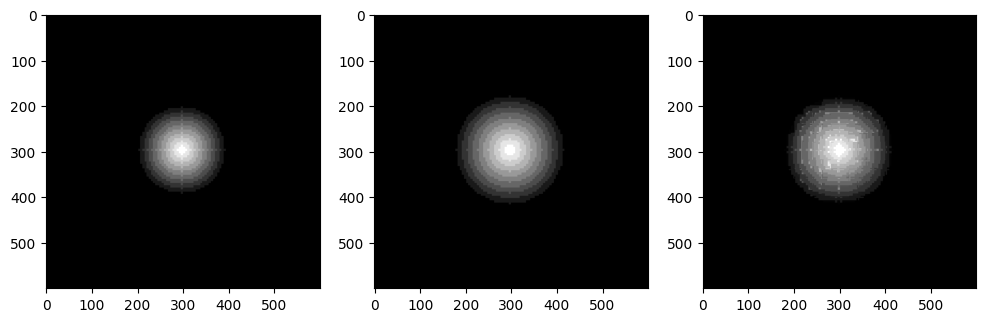

In [13]:
decoded_E_dct = decode_RLE(B_E_encoded)
decoded_E = np.zeros(E.shape)

for i in range(n_blocks):
    for j in range(n_blocks):
        decoded_E[i * block_size: (i + 1) * block_size, j * block_size: (j+1) * block_size] = idct(idct(decoded_E_dct[i,j], axis=0, norm="ortho"), axis=1, norm="ortho")

decoded_E = np.rint(decoded_E).astype(np.int8)
decoded_image = np.clip(reconstructed + decoded_E, 0, 255)

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(decoded_image, cmap='gray')
plt.show()

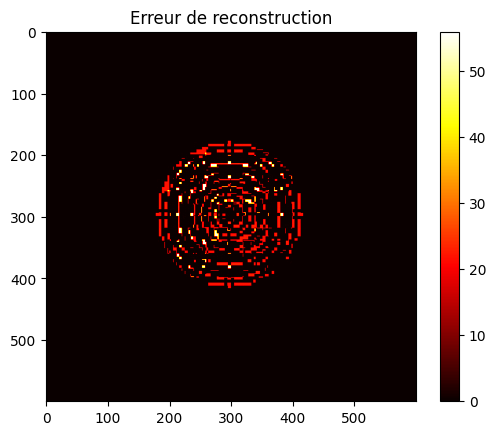

In [14]:
plt.imshow(np.abs(F2 - decoded_image), cmap='hot')
plt.title("Erreur de reconstruction")
plt.colorbar()
plt.show()

Le résultat possède des artéfacts visuels, possiblement dûs à une erreur d'implémentation que je n'ai pas réussi à résoudre.

Maintenant en compressant l'image de base:

In [15]:
B_F1_dct = np.array([[[[0] * block_size] * block_size] * n_blocks] * n_blocks)

for i in range(n_blocks):
    for j in range(n_blocks):
        block = F1[i * block_size: (i + 1) * block_size, j * block_size: (j+1) * block_size]
        B_F1_dct[i,j] = dct(dct(block, axis=0, norm="ortho"), axis=1, norm="ortho")

Q = 8
B_F1_dct = np.rint(B_F1_dct / Q).astype(np.int8)

B_F1_encoded = []

for i in range(n_blocks):
    for j in range(n_blocks):
        B_F1_encoded.append(RLE(B_F1_dct[i,j]))

size_before = asizeof.asizeof(F1)
size_after = asizeof.asizeof(B_F1_encoded)
print(f"Taille originale:{size_before}, taille encodée: {size_after}")
print(f"ratio de compression: {size_after / size_before:.2f}")

Taille originale:720168, taille encodée: 143984
ratio de compression: 0.20


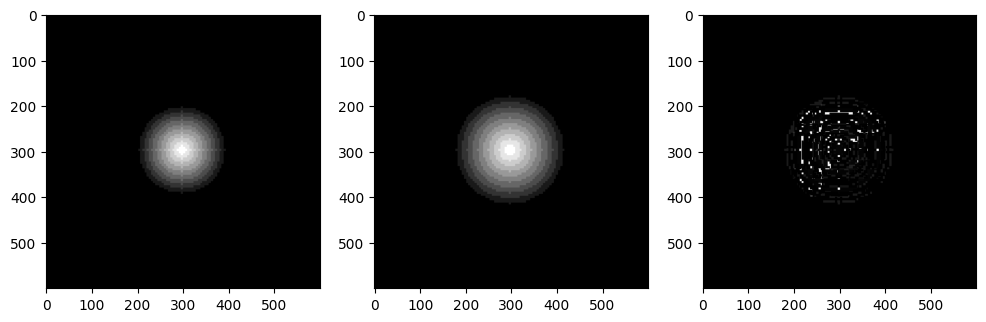

In [16]:
decoded_F1_dct = decode_RLE(B_F1_encoded)
decoded_F1 = np.zeros(F1.shape)

for i in range(n_blocks):
    for j in range(n_blocks):
        decoded_F1[i * block_size: (i + 1) * block_size, j * block_size: (j+1) * block_size] = idct(idct(decoded_F1_dct[i,j], axis=0, norm="ortho"), axis=1, norm="ortho")

decoded_F1 = np.rint(decoded_F1).astype(np.int8)

reconstructed = reconstruct_block(decoded_F1, B_Dx, B_Dy, block_size)
reconstructed_perfect = np.clip(decoded_F1 + E, 0, 255)

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed_perfect, cmap='gray')
plt.show()

Comme on peut le voir, l'image résultat n'est pas du tout celle attendue, encore une fois surement dû à une erreur d'implémentation que je ne comprends pas. Néanmoins, on peut compresser l'image en JPEG par la bibliothèque PIL, pour avoir un algorithme similair et compresser l'image:

Taille originale:360144, taille encodée: 6672
ratio de compression: 0.02


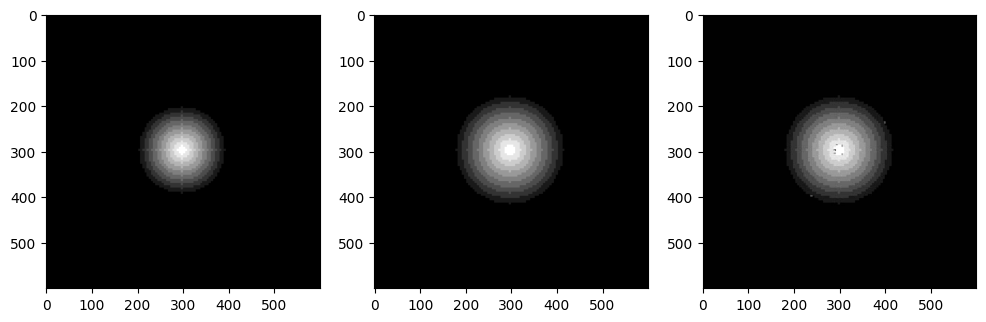

In [19]:
import io

buffer = io.BytesIO()
Image.open("../images_synthetiques/1.png").convert("L").save(buffer, format="JPEG", quality=40)

buffer.seek(0)
img_compressed = Image.open(buffer)

size_before = asizeof.asizeof(F1.astype(np.uint8))
size_after = asizeof.asizeof(buffer)

print(f"Taille originale:{size_before}, taille encodée: {size_after}")
print(f"ratio de compression: {size_after / size_before:.2f}")

img = np.array(img_compressed)

reconstructed = reconstruct_block(img, B_Dx, B_Dy, block_size)
reconstructed_with_error = reconstructed + E

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1, dtype=np.uint8), cmap='gray')
ax[1].imshow(np.asarray(F2, dtype=np.uint8), cmap='gray')
ax[2].imshow(reconstructed_with_error, cmap='gray')
plt.show()

Comme on peut le voir, le résultat est très correct malgrès quelques artéfacts. On peut donc en déduire que à la fois l'image référence et l'erreur de reconstruction peuvent être compressées.